# Clasificación no supervisada de notas

In [1]:
# !pip install -U kaleido
# !pip install plotly
# !pip install cluster
# !pip install yellowbrick
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import cluster
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans




Convertimos el raw_dataset en un pandas dataframe con el formato que nos interesa

In [2]:
data1920 = pd.read_excel('data/raw_dataset.xlsx', sheet_name='Applied Computing', index_col=None, na_values=['No terminado'], usecols = "A:D", skiprows=1)
data1920.dropna(how='all', inplace=True)
data1920.insert(loc=0, column = 'Curso', value = '19/20')
data1920.head()

Curso      #      Id  Score                    Date
0  19/20  838.0  3175.0    8.5  2020-03-30 18:35:15+02
1  19/20  837.0  3209.0    7.5  2020-03-30 17:16:20+02
2  19/20  836.0  3229.0    8.5  2020-03-30 11:23:42+02
3  19/20  835.0  3229.0    NaN  2020-03-30 10:48:41+02
4  19/20  834.0  3229.0    NaN  2020-03-30 10:47:22+02

In [3]:
data1819 = pd.read_excel('data/raw_dataset.xlsx', sheet_name='Applied Computing', index_col=None, na_values=['No terminado'], usecols = "E:H", skiprows=19)
data1819.dropna(how='all', inplace=True)
data1819.insert(loc=0, column = 'Curso', value = '18/19')
data1819.head()

Curso       #      Id  Score                    Date
0  18/19  1175.0  3021.0    9.0  2019-05-21 20:10:52+02
1  18/19  1174.0  2865.0    5.5  2019-05-21 15:35:20+02
2  18/19  1173.0  2851.0    9.0  2019-05-21 15:33:15+02
3  18/19  1172.0  2821.0    6.0  2019-05-21 13:38:42+02
4  18/19  1171.0  2736.0    5.5  2019-05-21 13:37:20+02

In [4]:
data1718 = pd.read_excel('data/raw_dataset.xlsx', sheet_name='Applied Computing', index_col=None, na_values=['No terminado'], usecols = "I:L", skiprows=69)
data1718.dropna(how='all', inplace=True)
data1718.insert(loc=0, column = 'Curso', value = '17/18')
data1718.head()

Curso     #    Id  Score                    Date
0  17/18  1345  2311    8.0  2018-06-01 15:03:04+02
1  17/18  1344  2308    8.0  2018-06-01 15:01:31+02
2  17/18  1343  2276    9.5  2018-06-01 14:51:46+02
3  17/18  1342  2276    8.5  2018-06-01 14:07:59+02
4  17/18  1341  2300    6.0  2018-06-01 14:06:12+02

In [5]:
dataComputing = pd.concat([data1718, data1819, data1920], ignore_index=True)
dataComputing.columns = ['CURSO', 'SEQ', 'ID', 'SCORE', 'DATE']
dataComputing['DATE'] = pd.to_datetime(dataComputing.DATE)
dataComputing.head()

CURSO     SEQ      ID  SCORE                       DATE
0  17/18  1345.0  2311.0    8.0  2018-06-01 15:03:04+02:00
1  17/18  1344.0  2308.0    8.0  2018-06-01 15:01:31+02:00
2  17/18  1343.0  2276.0    9.5  2018-06-01 14:51:46+02:00
3  17/18  1342.0  2276.0    8.5  2018-06-01 14:07:59+02:00
4  17/18  1341.0  2300.0    6.0  2018-06-01 14:06:12+02:00

In [6]:
max_dates = {curso: max(dataComputing[dataComputing.CURSO == curso].DATE) for curso in dataComputing.CURSO.unique()}
max_dates

{'17/18': datetime.datetime(2018, 6, 1, 15, 3, 4, tzinfo=tzoffset(None, 7200)),
 '18/19': datetime.datetime(2019, 5, 21, 20, 10, 52, tzinfo=tzoffset(None, 7200)),
 '19/20': datetime.datetime(2020, 3, 30, 18, 35, 15, tzinfo=tzoffset(None, 7200))}

In [7]:
dataComputing['DUF'] = [(max_dates[curso]-fecha).days for curso, fecha in dataComputing[['CURSO', 'DATE']].values]

In [8]:
dataComputing.head()

CURSO     SEQ      ID  SCORE                       DATE  DUF
0  17/18  1345.0  2311.0    8.0  2018-06-01 15:03:04+02:00    0
1  17/18  1344.0  2308.0    8.0  2018-06-01 15:01:31+02:00    0
2  17/18  1343.0  2276.0    9.5  2018-06-01 14:51:46+02:00    0
3  17/18  1342.0  2276.0    8.5  2018-06-01 14:07:59+02:00    0
4  17/18  1341.0  2300.0    6.0  2018-06-01 14:06:12+02:00    0

Así llegamos a un DataFrame cuyas columnas son las siguientes:
- **CURSO**: identificación del curso. Sus valores son: '17/18', '18/19', '19/20'
- **SEQ**: identificador del examen dentro del curso. Este número se puede encontrar repetido para distintos cursos.
- **ID**: identificador del alumno. Un alumno se puede encontrar en distintos cursos a la vez.
- **SCORE**: puntuación de un SEQ para un ID, es decir, es la puntuación obtenida de un alumno para un examen.
- **DATE**: fecha del examen.
- **DUF**: días hasta el último examen realizado de cada curso.

# Desarrollo de test para el dataset

In [9]:
[False for curso in dataComputing.CURSO.unique() if curso not in ['17/18', '18/19', '19/20']]

[]

In [10]:
len([curso for curso in dataComputing.CURSO.unique() if curso not in ['17/18', '18/19', '19/20']])


0

In [11]:
len([nota for nota in dataComputing.SCORE.unique() if (nota>10)|(nota<0) ])

0

In [12]:
len([duf for duf in dataComputing.DUF.unique() if (duf<0) ])

0

In [13]:
# Comprobación de que un alumno puede estar en distintos cursos, por lo que no nos vale como test
alumnos1718 = list(set(dataComputing[dataComputing.CURSO == '17/18'].ID))
alumnos1819 = list(set(dataComputing[dataComputing.CURSO == '18/19'].ID))
alumnos1920 = list(set(dataComputing[dataComputing.CURSO == '19/20'].ID))
for i in alumnos1819:
    if i in alumnos1920:
        print(f"El alumno {i} aparece en el curso 18/19")

El alumno 2.0 aparece en el curso 18/19


In [14]:
#Debido a que el alumno 2 aparece en varios cursos Y sus notas están todas a null, eliminamos el registro del estudio
dataComputing.drop(dataComputing[dataComputing.ID == 2].index, inplace=True)

In [15]:
data1 = dataComputing.copy(deep=True)
data2 = dataComputing.copy(deep=True)
data3 = dataComputing.copy(deep=True)

# Caso 1: agrupación de las notas en las 3 últimas y realizar el clustering

In [59]:
# Distintas opciones con los "No terminados"
# data1 = dataComputing[pd.isnull(dataComputing.SCORE)==False]
# data1.drop(['SEQ'], axis = 1, inplace = True)
data1 = data1.replace(np.nan, 0)

In [60]:
data1.head()

CURSO     SEQ      ID  SCORE                       DATE  DUF
0  17/18  1345.0  2311.0    8.0  2018-06-01 15:03:04+02:00    0
1  17/18  1344.0  2308.0    8.0  2018-06-01 15:01:31+02:00    0
2  17/18  1343.0  2276.0    9.5  2018-06-01 14:51:46+02:00    0
3  17/18  1342.0  2276.0    8.5  2018-06-01 14:07:59+02:00    0
4  17/18  1341.0  2300.0    6.0  2018-06-01 14:06:12+02:00    0

In [61]:
data1 = data1.groupby(['ID', 'CURSO'])['SCORE', 'DATE', 'DUF'].apply(lambda x: x.sort_values(['DATE'], ascending=False).head(3))
data1.head(12)

<ipython-input-61-0b89dec8e77a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data1 = data1.groupby(['ID', 'CURSO'])['SCORE', 'DATE', 'DUF'].apply(lambda x: x.sort_values(['DATE'], ascending=False).head(3))


SCORE                       DATE  DUF
ID     CURSO                                           
2032.0 17/18 12     0.0  2018-06-01 13:23:20+02:00    0
2213.0 17/18 56     8.0  2018-06-01 11:50:03+02:00    0
             140    6.5  2018-06-01 00:38:06+02:00    0
             188    3.0  2018-05-31 20:31:40+02:00    0
2215.0 17/18 75     8.5  2018-06-01 11:16:11+02:00    0
             135    7.5  2018-06-01 01:42:42+02:00    0
             182   10.0  2018-05-31 20:37:15+02:00    0
2217.0 17/18 9      0.0  2018-06-01 13:38:22+02:00    0
             464    6.0  2018-05-30 16:08:59+02:00    1
             473    0.0  2018-05-30 14:13:01+02:00    2
2218.0 17/18 53     8.5  2018-06-01 11:57:50+02:00    0
             83     7.5  2018-06-01 10:46:05+02:00    0

## Caso 1.1: Solamente considerando los SCORE

In [19]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, value in data1.reset_index(drop=False)[['ID', 'SCORE']].values:
    if id in dicc.keys():
        dicc[id] += [value]
    else:
        dicc[id] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data11 = pd.DataFrame.from_dict(dicc, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3'])
data11.head()

SCORE1  SCORE2  SCORE3
2032.0     0.0     0.0     0.0
2213.0     8.0     6.5     3.0
2215.0     8.5     7.5    10.0
2217.0     0.0     6.0     0.0
2218.0     8.5     7.5     8.5

In [20]:
data11_test = data11.copy(deep=True)

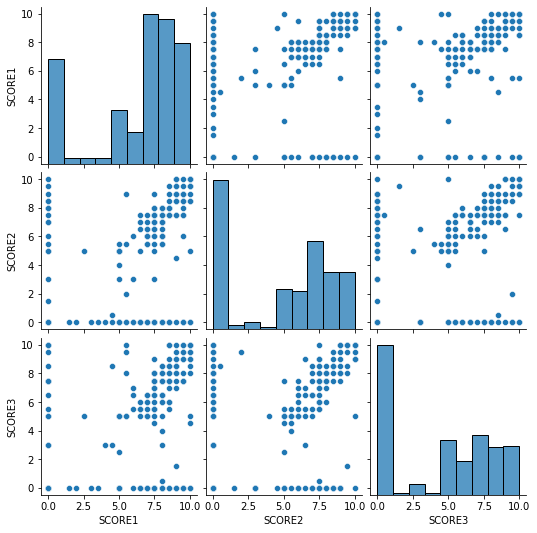

In [21]:
sns_plot11 = sns.pairplot(data11)
sns_plot11.savefig("out/caso1/pairplotCaso11.png")

In [22]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data11 = min_max_scaler.fit_transform(data11)

Text(0.5, 0, 'SCORE3')

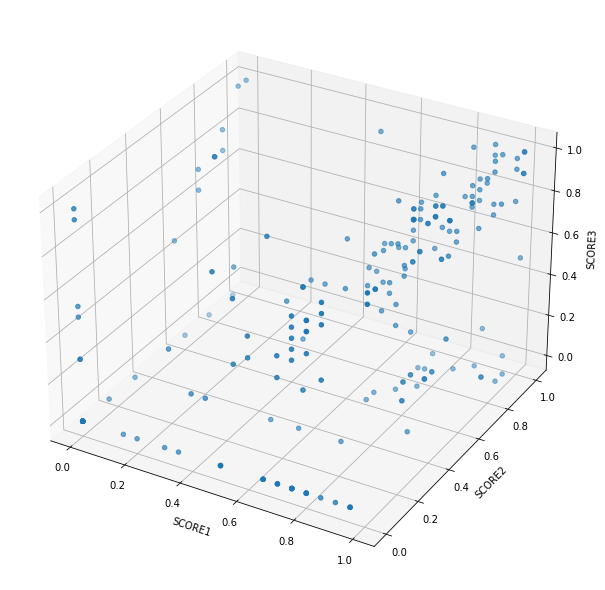

In [23]:
# Gráfico 3D para la dispersión
fig = plt.figure(figsize=(8.,35.))
ax = Axes3D(fig)
ax.scatter(data11[:, 0], data11[:, 1], data11[:, 2])

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

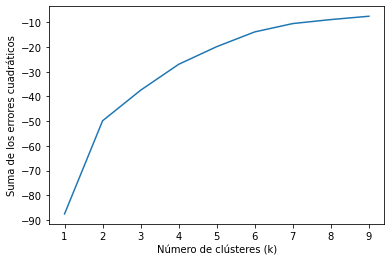

In [24]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data11).score(data11) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso1/codo2Caso1.png")
plt.plot(nc,score)

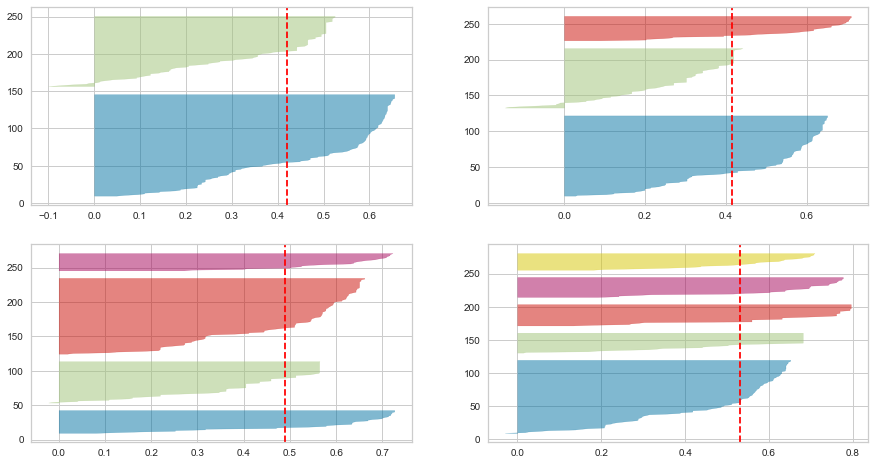

In [25]:
# Buscamos el número de clusters con Silhouette
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data11)

In [82]:
# Aplicamos un k-means de 5 cluster
kmeans = cluster.KMeans(n_clusters=5).fit(data11)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.79193548 0.73064516 0.02419355]
 [0.7015625  0.028125   0.01875   ]
 [0.73727273 0.75863636 0.73409091]
 [0.03125    0.1328125  0.0671875 ]
 [0.67962963 0.02407407 0.7462963 ]]


Text(0.5, 0, 'SCORE3')

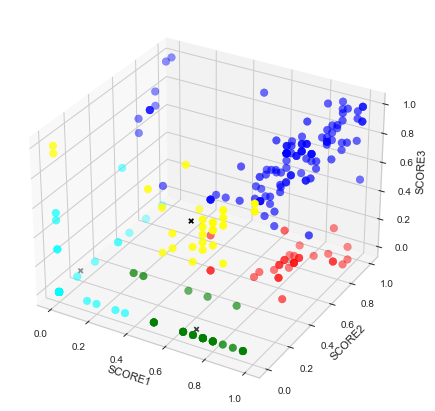

In [83]:
labels = kmeans.predict(data11)
colores=['red','green','blue','cyan', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data11[:, 0], data11[:, 1], data11[:, 2], c=asignar,s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='black')

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

## Caso 1.2: Añadimos los cursos

In [26]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, curso, value in data1.reset_index(drop=False)[['ID', 'CURSO', 'SCORE']].values:
    if (id,curso) in dicc.keys():
        dicc[(id, curso)] += [value]
    else:
        dicc[(id, curso)] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data12 = pd.DataFrame.from_dict(dicc, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3'])
data12['CURSO'] = [curso for id,curso in data12.reset_index(drop=False)['index'].values]
data12.reset_index(drop=False).head()

index  SCORE1  SCORE2  SCORE3  CURSO
0  (2032.0, 17/18)     0.0     0.0     0.0  17/18
1  (2213.0, 17/18)     8.0     6.5     3.0  17/18
2  (2215.0, 17/18)     8.5     7.5    10.0  17/18
3  (2217.0, 17/18)     0.0     6.0     0.0  17/18
4  (2218.0, 17/18)     8.5     7.5     8.5  17/18

In [27]:
data12_test = data12.copy(deep=True)

In [28]:
# Binarizamos el curso
data12 = pd.concat((data12, pd.get_dummies(data12["CURSO"])), axis = 1).drop("CURSO", 1)
data12.head()

SCORE1  SCORE2  SCORE3  17/18  18/19  19/20
(2032.0, 17/18)     0.0     0.0     0.0      1      0      0
(2213.0, 17/18)     8.0     6.5     3.0      1      0      0
(2215.0, 17/18)     8.5     7.5    10.0      1      0      0
(2217.0, 17/18)     0.0     6.0     0.0      1      0      0
(2218.0, 17/18)     8.5     7.5     8.5      1      0      0

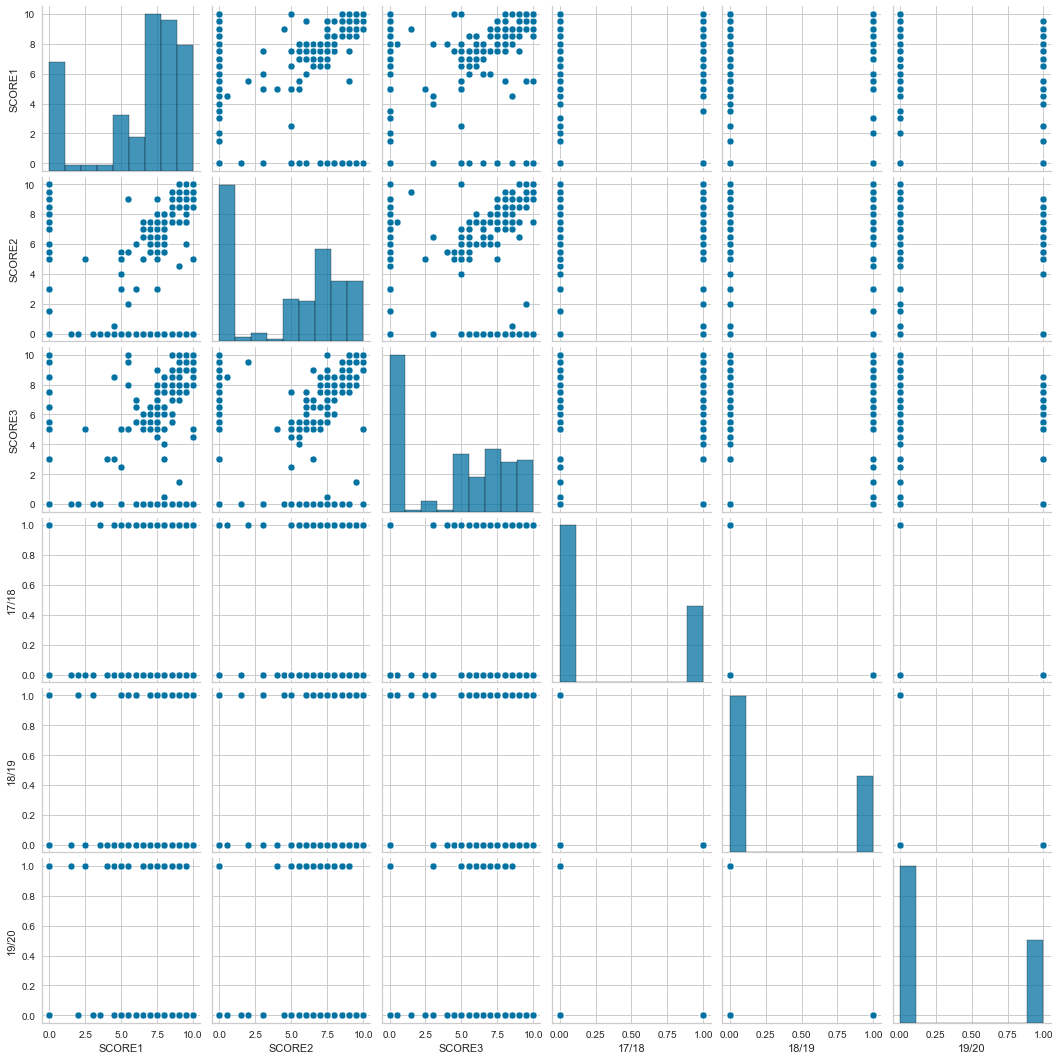

In [29]:
sns_plot12 = sns.pairplot(data12)
sns_plot12.savefig("out/caso1/pairplotCaso12.png")

In [30]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data12 = min_max_scaler.fit_transform(data12)

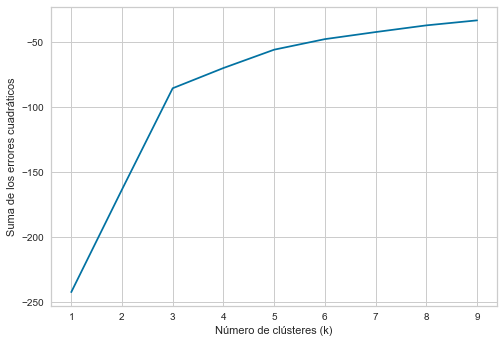

In [31]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data12).score(data12) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso1/codo2Caso1.png")
plt.plot(nc,score)

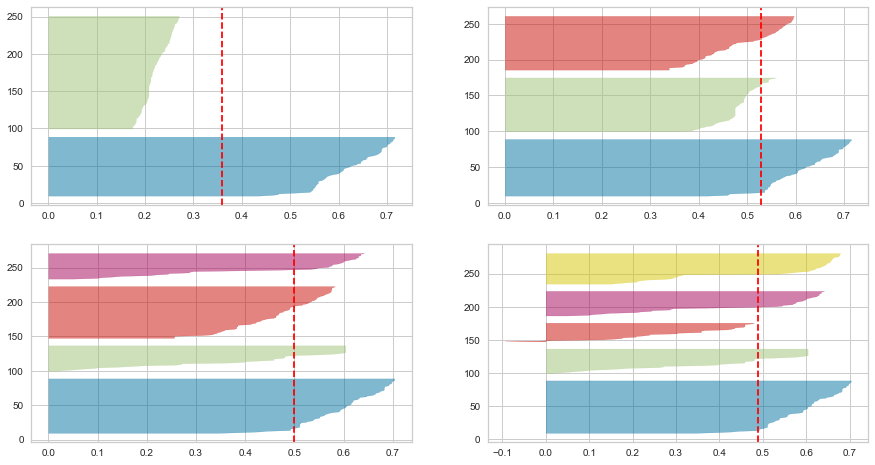

In [32]:
# Buscamos el número de clusters con Silhouette
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data12)

In [91]:
# Aplicamos un k-means de 3 cluster
kmeans = cluster.KMeans(n_clusters=3).fit(data12)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 6.73026316e-01  5.36842105e-01  5.51315789e-01  1.00000000e+00
   5.55111512e-17 -1.66533454e-16]
 [ 6.68125000e-01  4.85000000e-01  4.12500000e-01  5.55111512e-17
   5.55111512e-17  1.00000000e+00]
 [ 5.63815789e-01  4.25000000e-01  3.88157895e-01  5.55111512e-17
   1.00000000e+00 -1.66533454e-16]]


Text(0.5, 0, 'SCORE3')

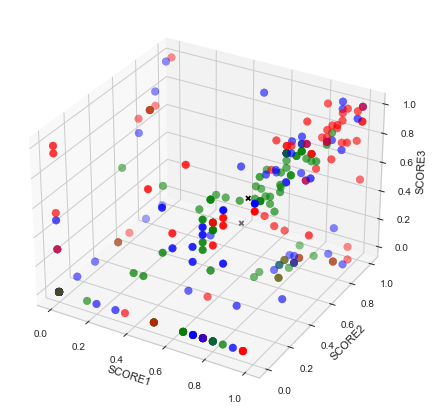

In [92]:
labels = kmeans.predict(data12)
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data12[:, 0], data12[:, 1], data12[:, 2], c=asignar,s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='black')

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

## Caso 1.3: Considerando DUF

In [73]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, value in data1.reset_index(drop=False)[['ID', 'SCORE']].values:
    if id in dicc.keys():
        dicc[id] += [value]
    else:
        dicc[id] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data13 = pd.DataFrame.from_dict(dicc, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3'])
data13.head()

SCORE1  SCORE2  SCORE3
2032.0     0.0     0.0     0.0
2213.0     8.0     6.5     3.0
2215.0     8.5     7.5    10.0
2217.0     0.0     6.0     0.0
2218.0     8.5     7.5     8.5

In [74]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, value in data1.reset_index(drop=False)[['ID', 'DUF']].values:
    if id in dicc.keys():
        dicc[id] += [value]
    else:
        dicc[id] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data13_DUF = pd.DataFrame.from_dict(dicc, orient='index', columns=['DUF1', 'DUF2', 'DUF3'])
data13_DUF.head()

DUF1  DUF2  DUF3
2032.0   0.0   0.0   0.0
2213.0   0.0   0.0   0.0
2215.0   0.0   0.0   0.0
2217.0   0.0   1.0   2.0
2218.0   0.0   0.0   0.0

In [75]:
# Concatenamos para conseguir el df total
data13 = data13.join(data13_DUF)
data13_test = data13.copy(deep=True)
data13.head()

SCORE1  SCORE2  SCORE3  DUF1  DUF2  DUF3
2032.0     0.0     0.0     0.0   0.0   0.0   0.0
2213.0     8.0     6.5     3.0   0.0   0.0   0.0
2215.0     8.5     7.5    10.0   0.0   0.0   0.0
2217.0     0.0     6.0     0.0   0.0   1.0   2.0
2218.0     8.5     7.5     8.5   0.0   0.0   0.0

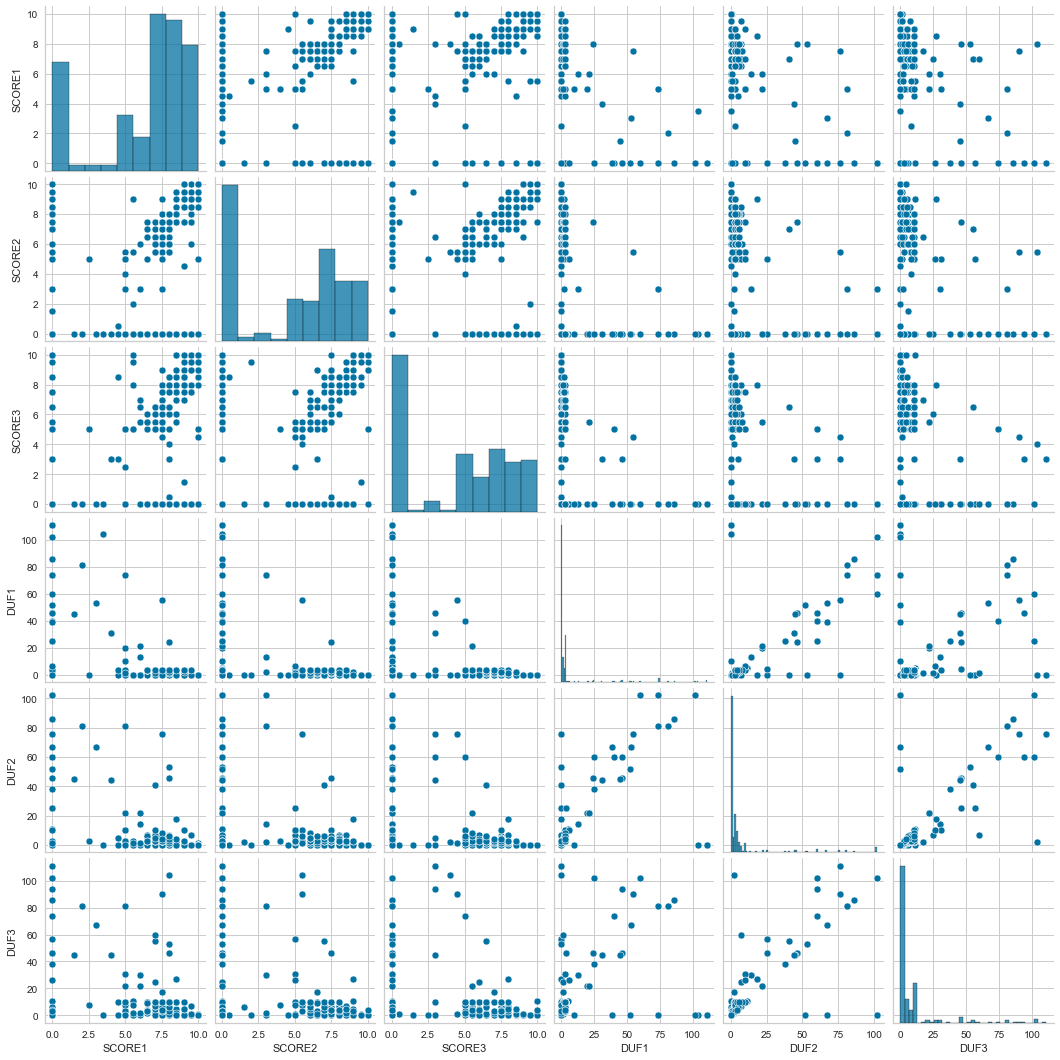

In [96]:
sns_plot13 = sns.pairplot(data13)
sns_plot13.savefig("out/caso1/pairplotCaso13.png")

In [65]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data13 = min_max_scaler.fit_transform(data13)

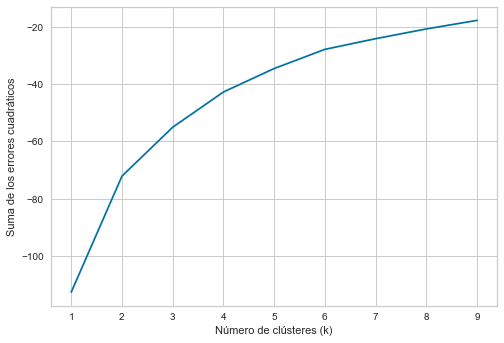

In [66]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data13).score(data13) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso1/codo2Caso1.png")
plt.plot(nc,score)

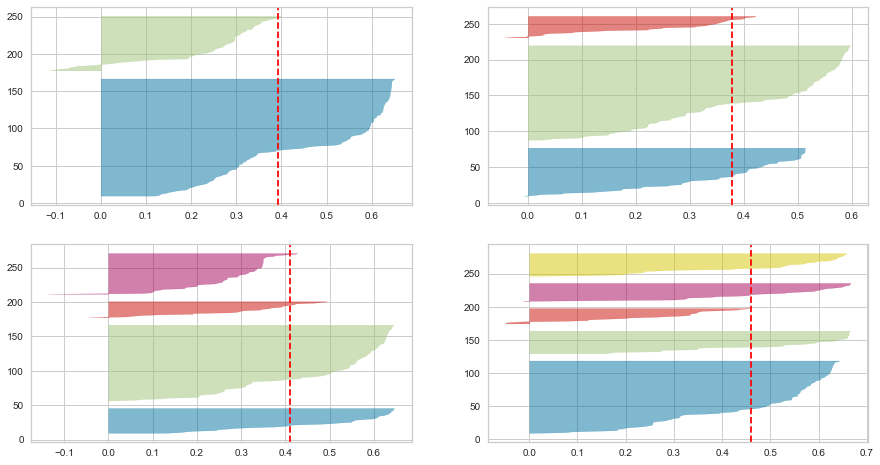

In [67]:
# Buscamos el número de clusters con Silhouette
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data13)

In [68]:
# Aplicamos un k-means de 5 cluster
kmeans = cluster.KMeans(n_clusters=5).fit(data13)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.72981651 0.76055046 0.73761468 0.00760393 0.02455478 0.04397058]
 [0.11041667 0.06875    0.07708333 0.50225225 0.57066993 0.43731231]
 [0.61571429 0.02142857 0.00857143 0.02033462 0.03977591 0.05791506]
 [0.70416667 0.72083333 0.03194444 0.01476476 0.03785403 0.07307307]
 [0.65535714 0.02321429 0.73928571 0.00997426 0.01645658 0.03120978]]


Text(0.5, 0, 'SCORE3')

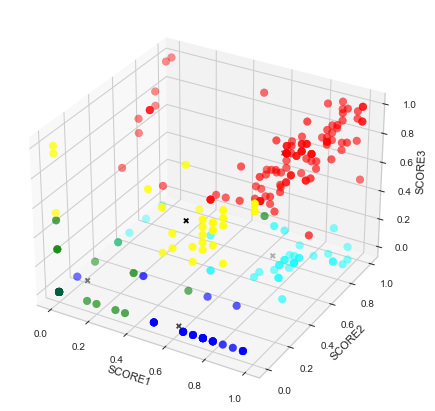

In [69]:
labels = kmeans.predict(data13)
colores=['red','green','blue', 'cyan', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data13[:, 0], data13[:, 1], data13[:, 2], c=asignar,s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='black')

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

In [76]:
data13_test['GRUPO'] = labels
data13_test.head()

SCORE1  SCORE2  SCORE3  DUF1  DUF2  DUF3  GRUPO
2032.0     0.0     0.0     0.0   0.0   0.0   0.0      2
2213.0     8.0     6.5     3.0   0.0   0.0   0.0      3
2215.0     8.5     7.5    10.0   0.0   0.0   0.0      0
2217.0     0.0     6.0     0.0   0.0   1.0   2.0      3
2218.0     8.5     7.5     8.5   0.0   0.0   0.0      0

In [77]:
cursos_por_est = {id: curso for id, curso in dataComputing[['ID', 'CURSO']].values}
data13_test['CURSO'] = [cursos_por_est[id] for id in data13_test.index]

In [78]:
data13_test[data13_test.GRUPO == 0].CURSO.value_counts()

19/20    43
17/18    38
18/19    28
Name: CURSO, dtype: int64

In [79]:
data13_test[data13_test.GRUPO == 1].CURSO.value_counts()

18/19    15
17/18     6
19/20     3
Name: CURSO, dtype: int64

In [80]:
data13_test[data13_test.GRUPO == 2].CURSO.value_counts()

18/19    12
19/20    12
17/18    11
Name: CURSO, dtype: int64

In [81]:
data13_test[data13_test.GRUPO == 3].CURSO.value_counts()

19/20    14
18/19    12
17/18    10
Name: CURSO, dtype: int64

In [82]:
data13_test[data13_test.GRUPO == 4].CURSO.value_counts()

17/18    11
18/19     9
19/20     8
Name: CURSO, dtype: int64

## Caso 14: Considerando SCORES y DUFS

In [39]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, curso, value in data1.reset_index(drop=False)[['ID', 'CURSO', 'SCORE']].values:
    if (id,curso) in dicc.keys():
        dicc[(id, curso)] += [value]
    else:
        dicc[(id, curso)] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data14 = pd.DataFrame.from_dict(dicc, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3'])
data14['CURSO'] = [curso for id,curso in data14.reset_index(drop=False)['index'].values]
data14['ID'] = [id for id,curso in data14.reset_index(drop=False)['index'].values]
data14 = pd.concat((data14, pd.get_dummies(data14["CURSO"])), axis = 1).drop("CURSO", 1)
data14.head()

SCORE1  SCORE2  SCORE3      ID  17/18  18/19  19/20
(2032.0, 17/18)     0.0     0.0     0.0  2032.0      1      0      0
(2213.0, 17/18)     8.0     6.5     3.0  2213.0      1      0      0
(2215.0, 17/18)     8.5     7.5    10.0  2215.0      1      0      0
(2217.0, 17/18)     0.0     6.0     0.0  2217.0      1      0      0
(2218.0, 17/18)     8.5     7.5     8.5  2218.0      1      0      0

In [40]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, value in data1.reset_index(drop=False)[['ID', 'DUF']].values:
    if id in dicc.keys():
        dicc[id] += [value]
    else:
        dicc[id] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data14_DUF = pd.DataFrame.from_dict(dicc, orient='index', columns=['DUF1', 'DUF2', 'DUF3'])
data14_DUF.head()

DUF1  DUF2  DUF3
2032.0   0.0   0.0   0.0
2213.0   0.0   0.0   0.0
2215.0   0.0   0.0   0.0
2217.0   0.0   1.0   2.0
2218.0   0.0   0.0   0.0

In [41]:
data14 = data14.reset_index(drop=True).set_index('ID').join(data14_DUF)
data14.head()

SCORE1  SCORE2  SCORE3  17/18  18/19  19/20  DUF1  DUF2  DUF3
ID                                                                   
2032.0     0.0     0.0     0.0      1      0      0   0.0   0.0   0.0
2213.0     8.0     6.5     3.0      1      0      0   0.0   0.0   0.0
2215.0     8.5     7.5    10.0      1      0      0   0.0   0.0   0.0
2217.0     0.0     6.0     0.0      1      0      0   0.0   1.0   2.0
2218.0     8.5     7.5     8.5      1      0      0   0.0   0.0   0.0

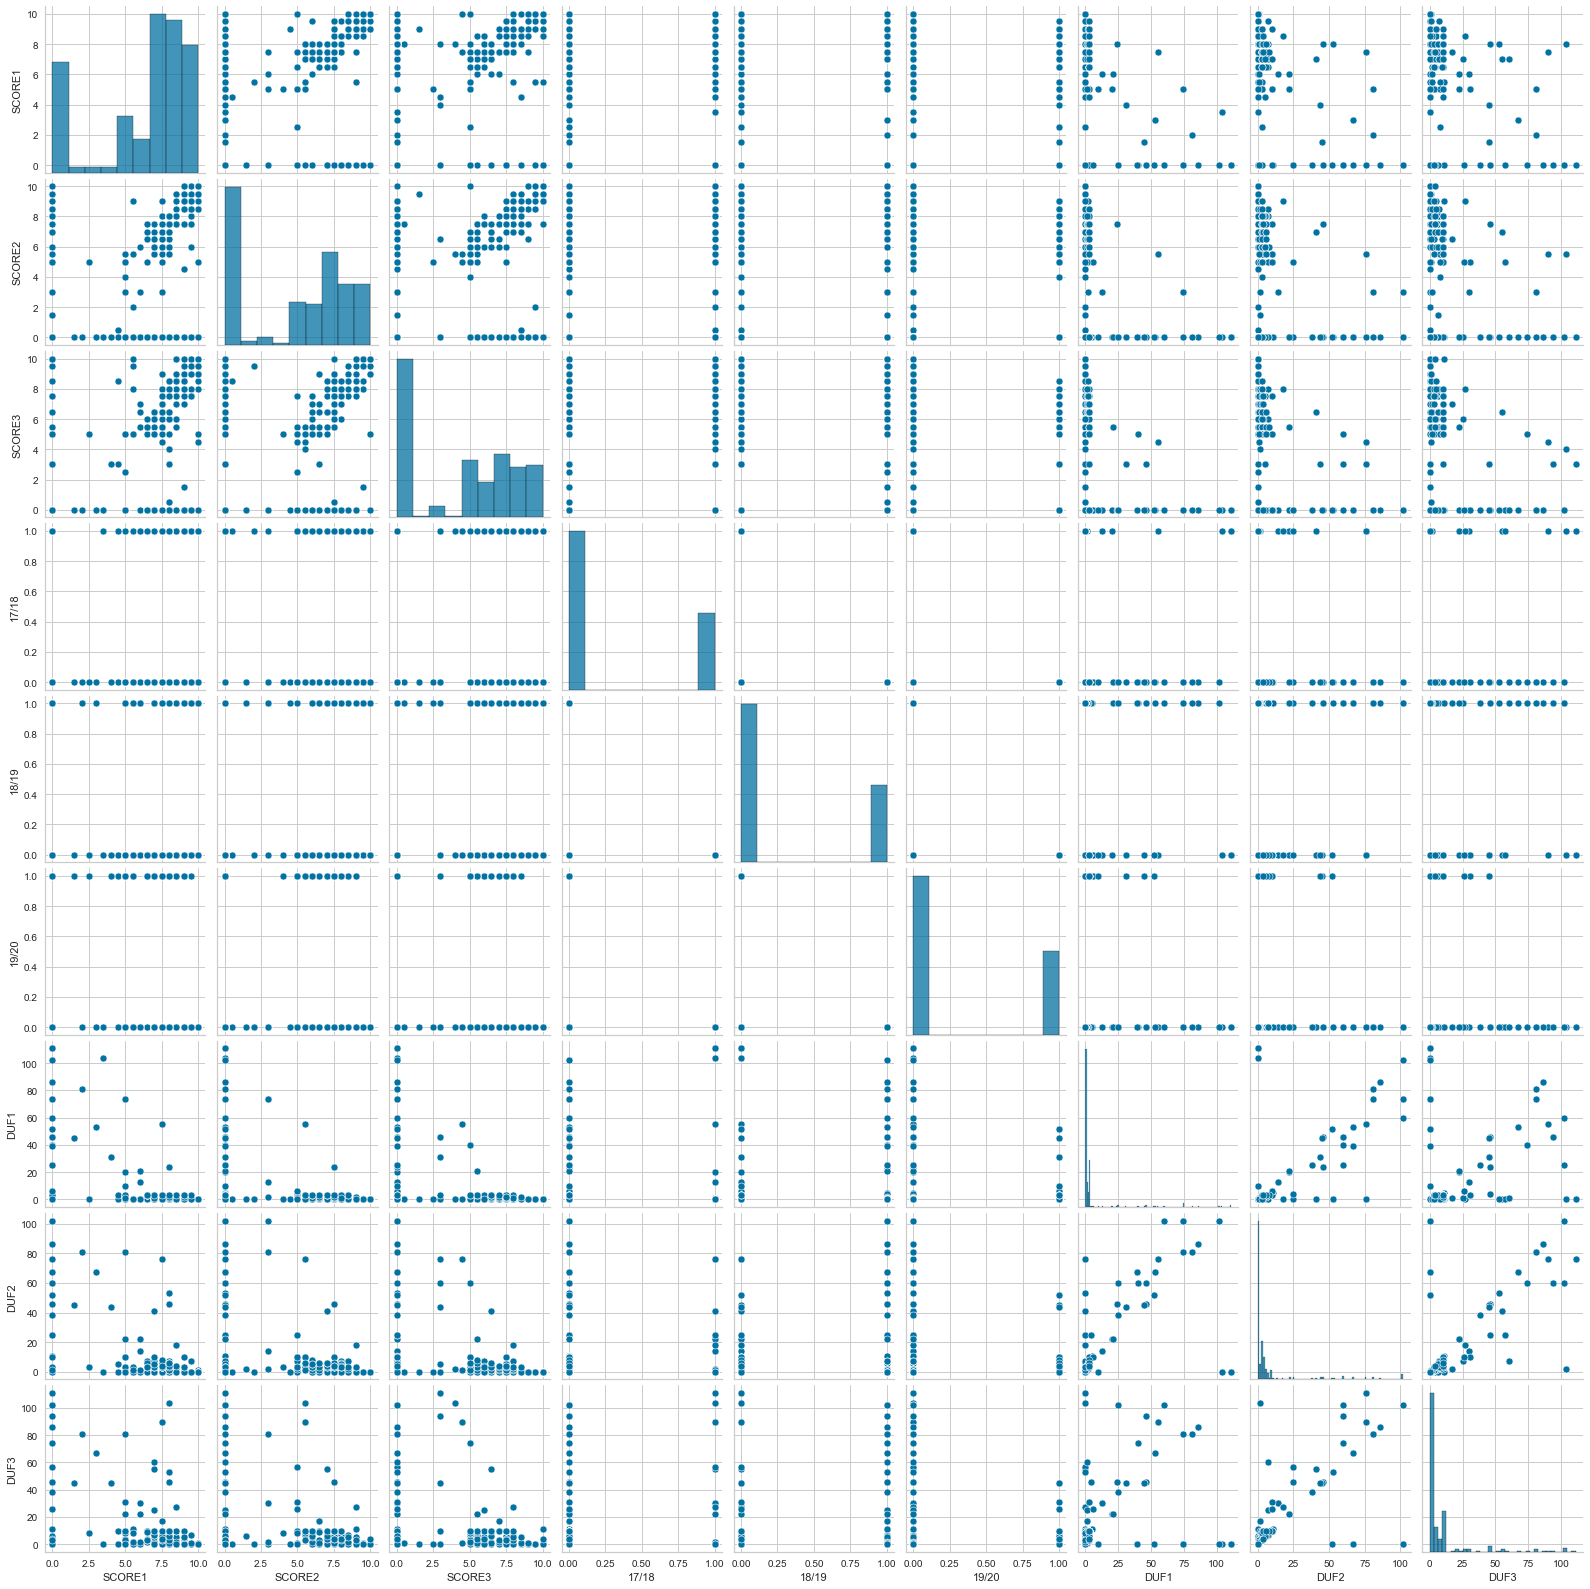

In [105]:
sns_plot14 = sns.pairplot(data14)
sns_plot14.savefig("out/caso1/pairplotCaso14.png")

In [42]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data14 = min_max_scaler.fit_transform(data14)

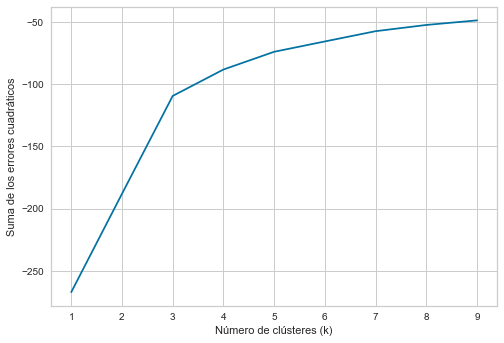

In [43]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data14).score(data14) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso1/codo2Caso1.png")
plt.plot(nc,score)

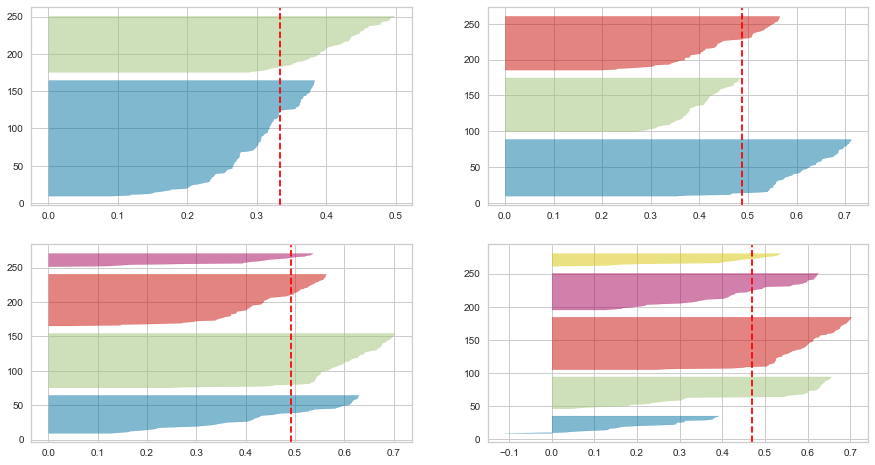

In [44]:
# Buscamos el número de clusters con Silhouette
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data14)

In [109]:
# Aplicamos un k-means de 5 cluster
kmeans = cluster.KMeans(n_clusters=3).fit(data14)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 6.73026316e-01  5.36842105e-01  5.51315789e-01  1.00000000e+00
   5.55111512e-17 -1.66533454e-16  4.91939308e-02  3.62487100e-02
   6.06922712e-02]
 [ 6.68125000e-01  4.85000000e-01  4.12500000e-01  5.55111512e-17
   5.55111512e-17  1.00000000e+00  3.28828829e-02  5.56372549e-02
   7.46621622e-02]
 [ 5.63815789e-01  4.25000000e-01  3.88157895e-01  5.55111512e-17
   1.00000000e+00 -1.66533454e-16  1.05737316e-01  1.62925697e-01
   1.34660977e-01]]


Text(0.5, 0, 'SCORE3')

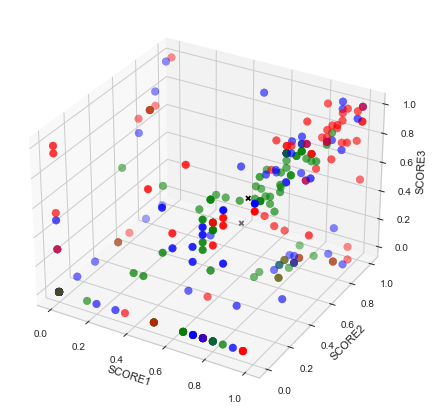

In [110]:
labels = kmeans.predict(data14)
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data14[:, 0], data14[:, 1], data14[:, 2], c=asignar,s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='black')

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

# Caso 2: Utilizando la media de cada estudiante de los 3 últimos meses

In [16]:
data2 = data2.replace(np.nan, 0)
data2['MONTH'] = [x.month for x in data2.DATE]
data2 = data2.groupby(['ID', 'CURSO'])['SCORE', 'MONTH', 'DUF'].apply(lambda x: x.groupby(['MONTH']).mean().head(3))

data2.head()

<ipython-input-16-070c6fb4d57e>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data2 = data2.groupby(['ID', 'CURSO'])['SCORE', 'MONTH', 'DUF'].apply(lambda x: x.groupby(['MONTH']).mean().head(3))


SCORE    DUF
ID     CURSO MONTH                 
2032.0 17/18 6      0.000000    0.0
2213.0 17/18 2      0.000000  111.0
             5      1.666667    0.0
             6      7.250000    0.0
2215.0 17/18 2      0.000000  105.6

## Caso 2.1: Utilizamos solamente el SCORE

In [17]:
len(data2.reset_index(drop=False)[['ID', 'SCORE']].values)

554

In [18]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, value in data2.reset_index(drop=False)[['ID', 'SCORE']].values:
    if id != 2:
        if id in dicc.keys():
            dicc[id] += [value]
        else:
            dicc[id] = [value]

for i in dicc.keys():
    while len(dicc[i]) < 3:
        dicc[i] += [0]

data21 = pd.DataFrame.from_dict(dicc, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3'])
data21.head()

SCORE1    SCORE2    SCORE3
2032.0   0.000  0.000000  0.000000
2213.0   0.000  1.666667  7.250000
2215.0   0.000  6.500000  5.600000
2217.0   4.000  5.000000  7.000000
2218.0   1.125  1.625000  1.071429

In [19]:
data21_test = data21.copy(deep=True)


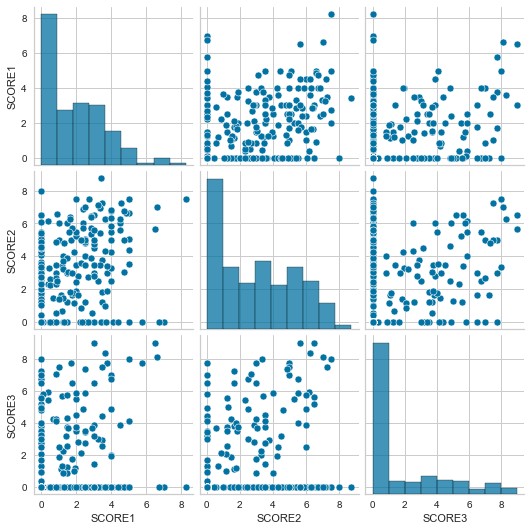

In [115]:
sns_plot21 = sns.pairplot(data21)
sns_plot21.savefig("out/caso1/pairplotCaso21.png")

In [20]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data21 = min_max_scaler.fit_transform(data21)

Text(0.5, 0, 'SCORE3')

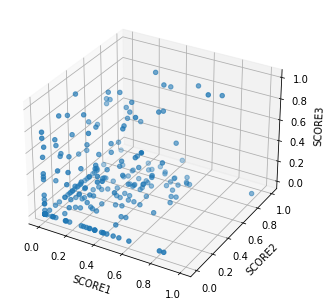

In [21]:
# Gráfico 3D para la dispersión
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data21[:, 0], data21[:, 1], data21[:, 2])

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

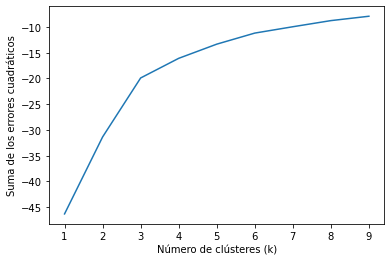

In [22]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data21).score(data21) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso1/codo2Caso1.png")
plt.plot(nc,score)

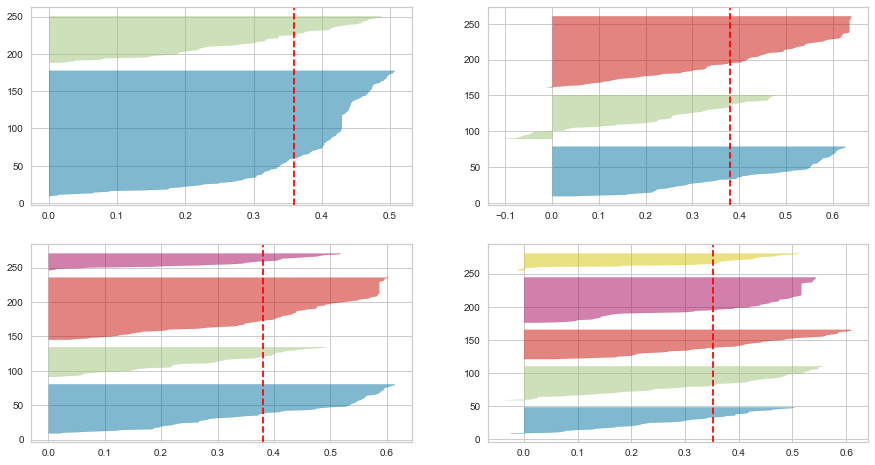

In [23]:
# Buscamos el número de clusters con Silhouette
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data21)

[[0.17023002 0.17441527 0.49765003]
 [0.08085939 0.41303534 0.03302959]
 [0.39970939 0.64291839 0.02418404]
 [0.17709281 0.04158156 0.02716677]
 [0.33208081 0.62076735 0.73354497]]


Text(0.5, 0, 'SCORE3')

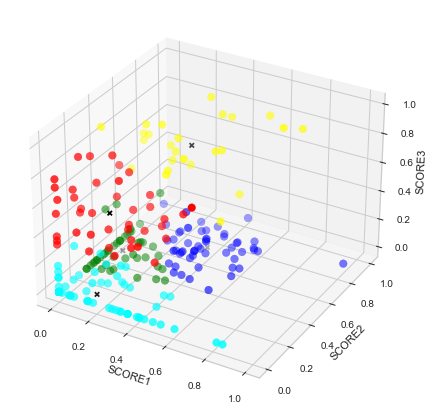

In [27]:
# Aplicamos un k-means de 5 cluster
kmeans = cluster.KMeans(n_clusters=5).fit(data21)
centroids = kmeans.cluster_centers_
print(centroids)

labels = kmeans.predict(data21)
colores=['red','green','blue','cyan', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data21[:, 0], data21[:, 1], data21[:, 2], c=asignar,s=60)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', c='black')

ax.set_xlabel('SCORE1')
ax.set_ylabel('SCORE2')
ax.set_zlabel('SCORE3')

In [28]:
data21_test['GRUPO'] = labels
data21_test.head()

SCORE1    SCORE2    SCORE3  GRUPO
2032.0   0.000  0.000000  0.000000      3
2213.0   0.000  1.666667  7.250000      0
2215.0   0.000  6.500000  5.600000      4
2217.0   4.000  5.000000  7.000000      4
2218.0   1.125  1.625000  1.071429      3

In [40]:
cursos_por_est = {id: curso for id, curso in dataComputing[['ID', 'CURSO']].values}
data21_test['CURSO'] = [cursos_por_est[id] for id in data21_test.index]

In [52]:
data21_test[data21_test.GRUPO == 0].CURSO.value_counts()

17/18    22
18/19    19
Name: CURSO, dtype: int64

In [55]:
data21_test[data21_test.GRUPO == 1].CURSO.value_counts()

19/20    31
18/19    11
17/18     3
Name: CURSO, dtype: int64

In [56]:
data21_test[data21_test.GRUPO == 2].CURSO.value_counts()

19/20    37
18/19     8
17/18     7
Name: CURSO, dtype: int64

In [57]:
data21_test[data21_test.GRUPO == 3].CURSO.value_counts()

18/19    34
17/18    23
19/20    12
Name: CURSO, dtype: int64

In [58]:
data21_test[data21_test.GRUPO == 4].CURSO.value_counts()

17/18    21
18/19     4
Name: CURSO, dtype: int64

# Caso 3: Tener en cuenta todos los datos

In [14]:
data3 = dataComputing.copy(deep=True)
data3.replace(np.nan, 0, inplace = True)
data3['MONTH'] = [x.month for x in data3.DATE]

data3.head()

CURSO     SEQ      ID  SCORE                       DATE  DUF  MONTH
0  17/18  1345.0  2311.0    8.0  2018-06-01 15:03:04+02:00    0      6
1  17/18  1344.0  2308.0    8.0  2018-06-01 15:01:31+02:00    0      6
2  17/18  1343.0  2276.0    9.5  2018-06-01 14:51:46+02:00    0      6
3  17/18  1342.0  2276.0    8.5  2018-06-01 14:07:59+02:00    0      6
4  17/18  1341.0  2300.0    6.0  2018-06-01 14:06:12+02:00    0      6

In [15]:
data3.drop(data3[data3.ID==2.0].index, inplace = True)

In [16]:
data3 = data3.groupby(['ID', 'CURSO'])['SCORE', 'MONTH', 'DUF'].apply(lambda x: x.groupby(['MONTH']).mean())
data3.head()

<ipython-input-16-0edf7e9f3444>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data3 = data3.groupby(['ID', 'CURSO'])['SCORE', 'MONTH', 'DUF'].apply(lambda x: x.groupby(['MONTH']).mean())


SCORE    DUF
ID     CURSO MONTH                 
2032.0 17/18 6      0.000000    0.0
2213.0 17/18 2      0.000000  111.0
             5      1.666667    0.0
             6      7.250000    0.0
2215.0 17/18 2      0.000000  105.6

In [17]:
# Conseguimos un df tal que cada fila representa un id
dicc = dict()
for id, mes, value in data3.reset_index(drop=False)[['ID', 'MONTH', 'SCORE']].values:
    if (id, mes) in dicc.keys():
        dicc[(id, mes)] += [value]
    else:
        dicc[(id, mes)] = [value]

In [18]:
# "Rellenamos" los meses que no tienen nota con 0
for id in data3.reset_index(drop=False)['ID'].values:
    for i in range(6):
        if (id, i+1) not in dicc.keys():
            dicc[(id, i+1)] = [0.0]

In [19]:
final = {id:sum([dicc[(id, x+1)] for x in range(6)], []) for id in data3.reset_index(drop=False)['ID'].values}
data3 = pd.DataFrame.from_dict(final, orient='index', columns=['SCORE1', 'SCORE2', 'SCORE3', 'SCORE4', 'SCORE5', 'SCORE6']).reset_index(drop=False).rename(columns={'index':'ID'})
data3.head()

ID  SCORE1  SCORE2  SCORE3    SCORE4    SCORE5    SCORE6
0  2032.0     0.0   0.000   0.000  0.000000  0.000000  0.000000
1  2213.0     0.0   0.000   0.000  0.000000  1.666667  7.250000
2  2215.0     0.0   0.000   0.000  6.500000  5.600000  8.000000
3  2217.0     0.0   4.000   5.000  7.000000  3.000000  0.000000
4  2218.0     0.0   1.125   1.625  1.071429  5.571429  8.166667

In [20]:
data3.drop('SCORE1', axis=1, inplace = True)
data3.drop(data3[(data3.SCORE2 == 0.0) & (data3.SCORE3 == 0.0)& (data3.SCORE4 == 0.0)& (data3.SCORE5 == 0.0)& (data3.SCORE6 == 0.0)].index, inplace = True)

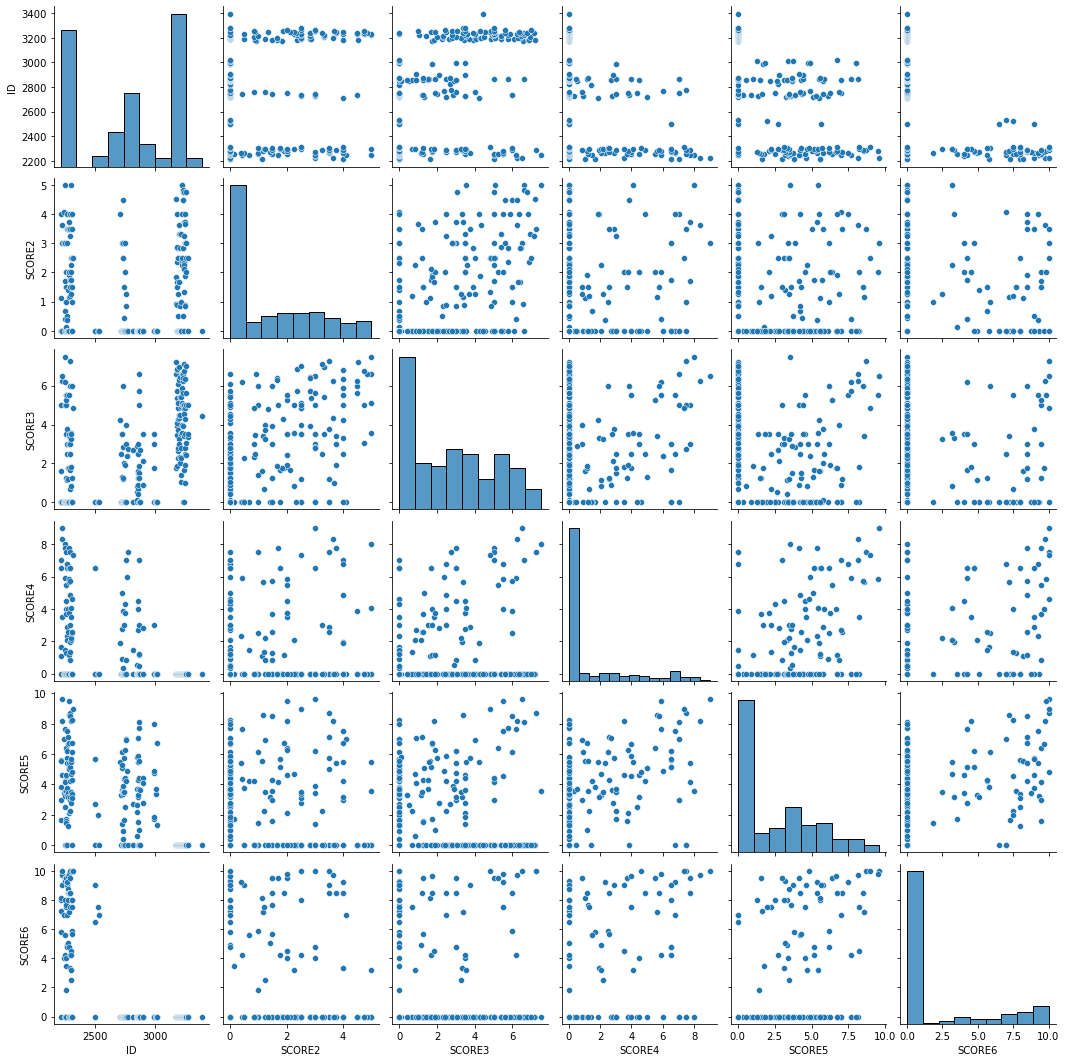

In [21]:
data3_test = data3.copy(deep=True)
sns_plot3 = sns.pairplot(data3)
sns_plot3.savefig("out/caso3/pairplotCaso3.png")


In [22]:
# Normalizamos los datos
min_max_scaler = preprocessing.MinMaxScaler() 
data3 = min_max_scaler.fit_transform(data3)

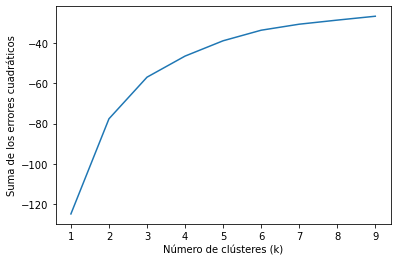

In [23]:
# Utilizando la suma de errores cuadráticos, extraemos el número de clusters
nc = range(1, 10)
kmeans = [cluster.KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(data3).score(data3) for i in range(len(kmeans))]

plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.savefig("out/caso3/codo2Caso3.png")
plt.plot(nc,score)

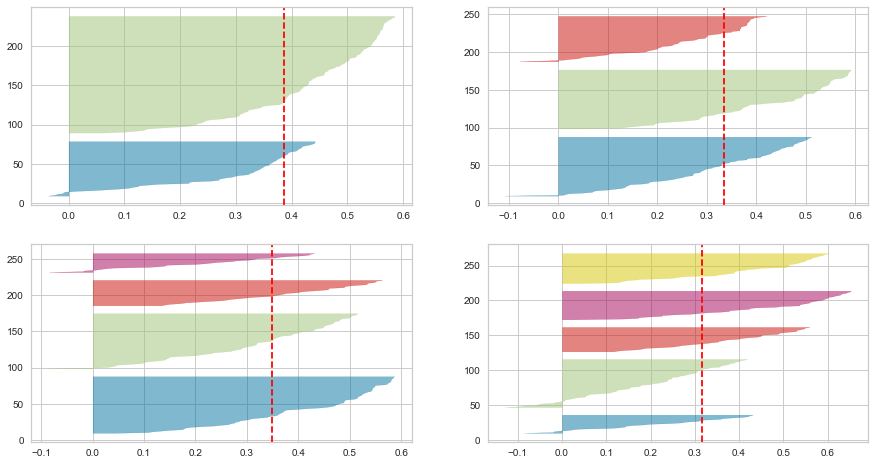

In [24]:
# Buscamos el número de clusters con Silhouette
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data3)


In [25]:
# Aplicamos un k-means de 5 cluster
kmeans = cluster.KMeans(n_clusters=5).fit(data3)
centroids = kmeans.cluster_centers_
print(centroids)

labels = kmeans.predict(data3)
colores=['red','green','blue','cyan', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])


[[ 8.23370768e-01  1.06148732e-01  4.35691095e-01 -2.77555756e-17
   4.57875458e-03 -8.32667268e-17]
 [ 6.63723741e-02  5.10432099e-01  6.15130316e-01  6.43707950e-01
   6.49665047e-01  6.28240741e-01]
 [ 8.28363944e-01  6.72523310e-01  6.87224303e-01  1.45833333e-02
   1.63352273e-02 -5.55111512e-17]
 [ 4.56092259e-01  1.15034014e-01  1.51589399e-01  1.19412323e-01
   3.62464150e-01  6.19047619e-03]
 [ 6.85873955e-02  1.53564815e-01  7.14506173e-02  1.84659630e-01
   3.81354618e-01  7.25964506e-01]]


In [26]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data3)

PCA()

In [27]:
pca.explained_variance_ratio_

array([0.48506768, 0.2530302 , 0.10584645, 0.07937231, 0.04792423,
       0.02875913])

Text(0, 0.5, 'Variabilidad acumulativa')

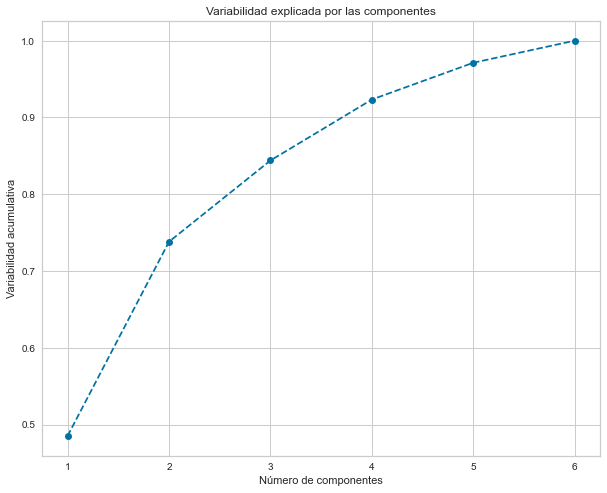

In [28]:
plt.figure(figsize = (10,8))
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Variabilidad explicada por las componentes")
plt.xlabel('Número de componentes')
plt.ylabel('Variabilidad acumulativa')

In [29]:
# Para conseguir el 80% de variabilidad, consideramos 3 componentes
pca = PCA(n_components = 3)
pca.fit(data3)
scores_pca = pca.transform(data3)

PCA(n_components=3)

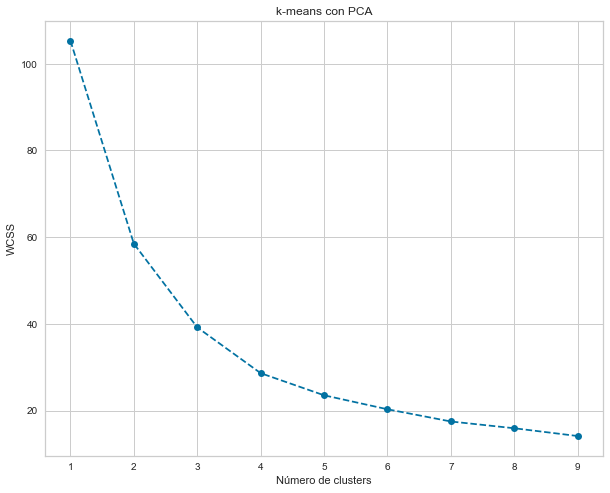

In [31]:
# Regla Elbow
wcss = []
for i in range(1,10):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('k-means con PCA')
plt.show()

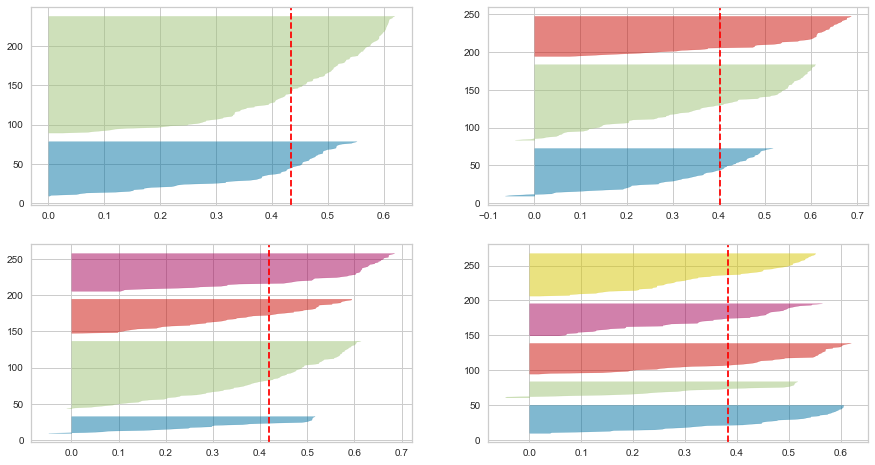

In [32]:
# Buscamos el número de clusters con Silhouette
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(scores_pca)

In [33]:
modelo2PCA = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
modelo2PCA.fit(scores_pca)

modelo3PCA = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
modelo3PCA.fit(scores_pca)

modelo4PCA = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
modelo4PCA.fit(scores_pca)

modelo5PCA = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
modelo5PCA.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [34]:
# Añadimos los resultados al df (las componentes y los grupos)
dffinal = pd.concat([data3_test.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
dffinal.columns.values[-3: ] = ['COMPONENTE1', 'COMPONENTE2', 'COMPONENTE3']
dffinal['GRUPO2'] = modelo2PCA.labels_
dffinal['GRUPO3'] = modelo3PCA.labels_
dffinal['GRUPO4'] = modelo4PCA.labels_
dffinal['GRUPO5'] = modelo5PCA.labels_
dffinal.head()

ID  SCORE2  SCORE3    SCORE4    SCORE5    SCORE6  COMPONENTE1  \
0  2213.0   0.000   0.000  0.000000  1.666667  7.250000     0.589609   
1  2215.0   0.000   0.000  6.500000  5.600000  8.000000     1.041284   
2  2217.0   4.000   5.000  7.000000  3.000000  0.000000     0.305509   
3  2218.0   1.125   1.625  1.071429  5.571429  8.166667     0.791245   
4  2219.0   0.000   0.000  1.666667  3.818182  5.800000     0.661528   

   COMPONENTE2  COMPONENTE3  GRUPO2  GRUPO3  GRUPO4  GRUPO5  
0    -0.392496    -0.310712       0       0       2       3  
1    -0.180253     0.149986       0       0       2       3  
2     0.696468     0.081384       0       0       0       1  
3    -0.038536    -0.171978       0       0       2       3  
4    -0.359507    -0.121657       0       0       2       3

In [37]:
# # Mapeamos los grupos (traducir!)
# dffinal['MAP'] = dffinal['GRUPO'].map({0:'first', 1:'second', 2:'third', 3:'fourth'})

Text(0.5, 0, 'COMP3')

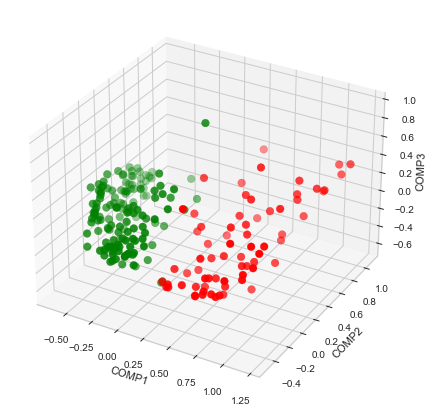

In [38]:
# Aplicamos un k-means de 2 cluster
labels = dffinal.GRUPO2.values
colores=['red','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dffinal['COMPONENTE1'].values, dffinal['COMPONENTE2'].values, dffinal['COMPONENTE3'].values, c=asignar,s=60)


ax.set_xlabel('COMP1')
ax.set_ylabel('COMP2')
ax.set_zlabel('COMP3')

Text(0.5, 0, 'COMP3')

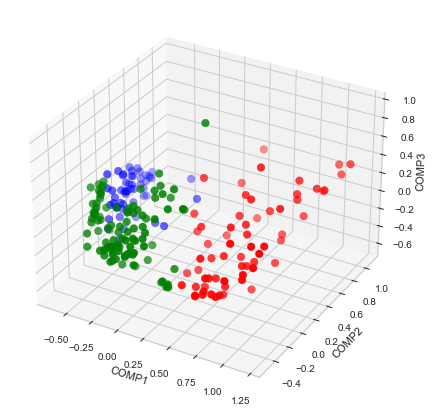

In [39]:
# Aplicamos un k-means de 3 cluster
labels = dffinal.GRUPO3.values
colores=['red','green', 'blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dffinal['COMPONENTE1'].values, dffinal['COMPONENTE2'].values, dffinal['COMPONENTE3'].values, c=asignar,s=60)


ax.set_xlabel('COMP1')
ax.set_ylabel('COMP2')
ax.set_zlabel('COMP3')

Text(0.5, 0, 'COMP3')

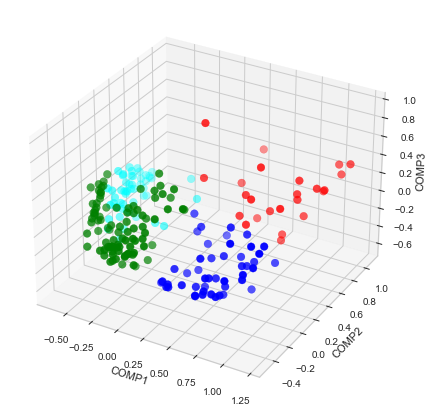

In [40]:
# Aplicamos un k-means de 4 cluster
labels = dffinal.GRUPO4.values
colores=['red','green','blue','cyan']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dffinal['COMPONENTE1'].values, dffinal['COMPONENTE2'].values, dffinal['COMPONENTE3'].values, c=asignar,s=60)


ax.set_xlabel('COMP1')
ax.set_ylabel('COMP2')
ax.set_zlabel('COMP3')

Text(0.5, 0, 'COMP3')

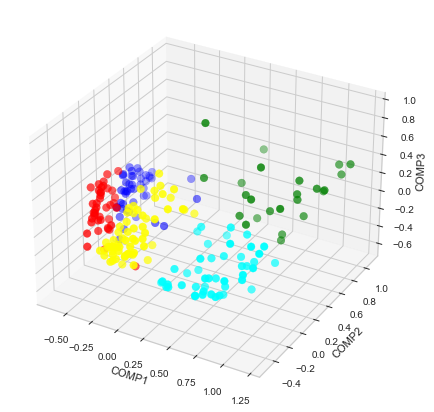

In [41]:
# Aplicamos un k-means de 5 cluster
labels = dffinal.GRUPO5.values
colores=['red','green','blue','cyan', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dffinal['COMPONENTE1'].values, dffinal['COMPONENTE2'].values, dffinal['COMPONENTE3'].values, c=asignar,s=60)


ax.set_xlabel('COMP1')
ax.set_ylabel('COMP2')
ax.set_zlabel('COMP3')

## Anexo: algoritmo del k-means con 5 grupos pero considerando únicamente 2 componentes principales

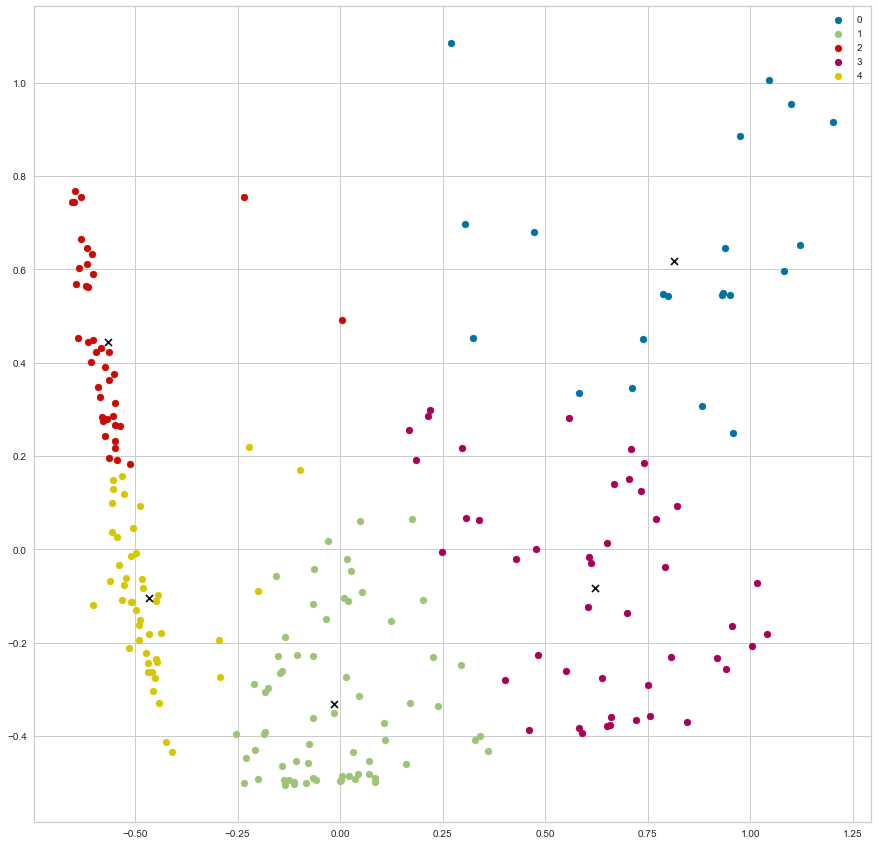

In [342]:
model1 = KMeans(n_clusters = 5, init = "k-means++")
label = model1.fit_predict(dataPCA)


plt.figure(figsize=(15,15))
uniq = np.unique(label)
for i in uniq:
  plt.scatter(dataPCA[label == i , 0] , dataPCA[label == i , 1] , label = i)

centers = np.array(model1.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
plt.legend()
plt.show()

## Definimos una función para describir los distintos conjuntos

Ahora que ya tenemos los distintos grupos, necesitamos un método que nos permita caracterizar los distintos grupos de alumnos conseguidos

In [170]:
pd.set_option('display.max_columns', None)

In [155]:
def estadisticos(df, scores):
    a = df.mean()[scores].values.tolist()
    a.extend(df.std()[scores].values)
    a.append(df[scores].mean().mean())
    a.append(df[scores].std().std())
    a.extend(df.median()[scores].values)
    a.append(df[scores].median().median())
    a.append(df.MEDIADUF.mean())
    a.append(df[df.CURSO == '17/18'].ID.count())
    a.append(df[df.CURSO == '18/19'].ID.count())
    a.append(df[df.CURSO == '19/20'].ID.count())
    return [round(d, 2) for d in a]

In [156]:
def caracterizar_grupos(dataComputing, dataset, GRUPO):
    cursos_por_est = {id: curso for id, curso in dataComputing[['ID', 'CURSO']].values}
    mediaDUF = {id: dataComputing.loc[dataComputing.ID == id, 'DUF'].mean() for id in dataComputing['ID'].values}
    dataset['CURSO'] = [cursos_por_est[id] for id in dataset['ID'].values]
    dataset['MEDIADUF'] = [mediaDUF[id] for id in dataset['ID'].values]
    scores = dataset.columns[dataset.columns.str.contains('SCORE')]
    columnas = ['MEDIA_SCORE2', 'MEDIA_SCORE3', 'MEDIA_SCORE4', 'MEDIA_SCORE5','MEDIA_SCORE6', 
            'SD_SCORE2', 'SD_SCORE3', 'SD_SCORE4', 'SD_SCORE5', 'SD_SCORE6', 'MEDIA', 'SD',
            'MEDIANA_SCORE2', 'MEDIANA_SCORE3', 'MEDIANA_SCORE4', 'MEDIANA_SCORE5','MEDIANA_SCORE6',
            'MEDIANA','MEDIA_DUF','N_CURSO1','N_CURSO2','N_CURSO3']
    
    dic = dict()
    for i in dataset[GRUPO].unique():
        dic['GRUPO{}'.format(i)] = estadisticos(dataset[dataset[GRUPO] == i], scores)
    
    return pd.DataFrame.from_dict(dic, orient='index', columns=columnas)

In [171]:
caracterizar_grupos(dataComputing, dffinal, 'GRUPO2' )

MEDIA_SCORE2  MEDIA_SCORE3  MEDIA_SCORE4  MEDIA_SCORE5  MEDIA_SCORE6  \
GRUPO0          1.62          2.09          3.22          4.65          6.22   
GRUPO1          1.30          2.96          0.48          1.52          0.00   

        SD_SCORE2  SD_SCORE3  SD_SCORE4  SD_SCORE5  SD_SCORE6  MEDIA    SD  \
GRUPO0       1.51       2.33       2.89       2.43       3.21   3.56  0.65   
GRUPO1       1.60       2.25       1.37       2.26       0.00   1.25  0.93   

        MEDIANA_SCORE2  MEDIANA_SCORE3  MEDIANA_SCORE4  MEDIANA_SCORE5  \
GRUPO0             1.5            1.25            2.55            4.57   
GRUPO1             0.0            2.83            0.00            0.00   

        MEDIANA_SCORE6  MEDIANA  MEDIA_DUF  N_CURSO1  N_CURSO2  N_CURSO3  
GRUPO0            7.38     2.55      33.13        69         1         0  
GRUPO1            0.00     0.00      25.31         3        67        79

In [172]:
caracterizar_grupos(dataComputing, dffinal, 'GRUPO3' )

MEDIA_SCORE2  MEDIA_SCORE3  MEDIA_SCORE4  MEDIA_SCORE5  MEDIA_SCORE6  \
GRUPO0          1.73          2.29          3.41          4.84          6.51   
GRUPO1          0.34          1.71          0.73          2.30          0.19   
GRUPO2          3.01          4.96          0.11          0.20          0.00   

        SD_SCORE2  SD_SCORE3  SD_SCORE4  SD_SCORE5  SD_SCORE6  MEDIA    SD  \
GRUPO0       1.52       2.34       2.84       2.31       3.08   3.75  0.60   
GRUPO1       0.77       1.74       1.70       2.47       1.02   1.05  0.67   
GRUPO2       1.17       1.55       0.58       0.92       0.00   1.66  0.59   

        MEDIANA_SCORE2  MEDIANA_SCORE3  MEDIANA_SCORE4  MEDIANA_SCORE5  \
GRUPO0             1.5            1.71            2.95            4.61   
GRUPO1             0.0            1.42            0.00            1.66   
GRUPO2             3.0            5.04            0.00            0.00   

        MEDIANA_SCORE6  MEDIANA  MEDIA_DUF  N_CURSO1  N_CURSO2  N_CURSO3  
GRUPO0             7.5     2.95      34.17        64         0         0  
GRUPO1             0.0     0.00      27.75         8        64        29  
GRUPO2             0.0     0.00      20.36         0         4        50

In [173]:
caracterizar_grupos(dataComputing, dffinal, 'GRUPO4' )

MEDIA_SCORE2  MEDIA_SCORE3  MEDIA_SCORE4  MEDIA_SCORE5  MEDIA_SCORE6  \
GRUPO2          1.26          0.73          1.60          3.69          5.88   
GRUPO0          2.48          4.93          6.18          6.25          6.39   
GRUPO1          0.26          1.83          0.70          2.28          0.00   
GRUPO3          3.07          4.94          0.11          0.20          0.00   

        SD_SCORE2  SD_SCORE3  SD_SCORE4  SD_SCORE5  SD_SCORE6  MEDIA    SD  \
GRUPO2       1.36       1.14       2.04       2.17       3.19   2.63  0.80   
GRUPO0       1.48       1.56       1.70       2.38       3.63   5.24  0.90   
GRUPO1       0.65       1.72       1.63       2.42       0.00   1.02  0.96   
GRUPO3       1.10       1.56       0.59       0.93       0.00   1.67  0.58   

        MEDIANA_SCORE2  MEDIANA_SCORE3  MEDIANA_SCORE4  MEDIANA_SCORE5  \
GRUPO2            1.06            0.00            0.96            3.44   
GRUPO0            2.25            5.12            6.50            6.19   
GRUPO1            0.00            1.67            0.00            1.69   
GRUPO3            3.00            5.00            0.00            0.00   

        MEDIANA_SCORE6  MEDIANA  MEDIA_DUF  N_CURSO1  N_CURSO2  N_CURSO3  
GRUPO2             7.0     1.06      32.44        48         0         0  
GRUPO0             8.0     6.19      38.66        23         1         0  
GRUPO1             0.0     0.00      26.95         1        63        30  
GRUPO3             0.0     0.00      20.21         0         4        49

In [174]:
caracterizar_grupos(dataComputing, dffinal, 'GRUPO5' )

MEDIA_SCORE2  MEDIA_SCORE3  MEDIA_SCORE4  MEDIA_SCORE5  MEDIA_SCORE6  \
GRUPO3          1.24          0.67          1.55          3.72          6.00   
GRUPO1          2.48          4.93          6.18          6.25          6.39   
GRUPO4          0.21          1.21          1.13          3.47          0.00   
GRUPO2          3.35          5.10          0.13          0.24          0.00   
GRUPO0          0.62          3.26          0.00          0.05          0.00   

        SD_SCORE2  SD_SCORE3  SD_SCORE4  SD_SCORE5  SD_SCORE6  MEDIA    SD  \
GRUPO3       1.37       1.08       2.03       2.18       3.10   2.64  0.79   
GRUPO1       1.48       1.56       1.70       2.38       3.63   5.24  0.90   
GRUPO4       0.61       1.44       1.93       2.19       0.00   1.20  0.92   
GRUPO2       0.92       1.53       0.64       1.01       0.00   1.76  0.56   
GRUPO0       0.84       1.59       0.00       0.29       0.00   0.78  0.68   

        MEDIANA_SCORE2  MEDIANA_SCORE3  MEDIANA_SCORE4  MEDIANA_SCORE5  \
GRUPO3            1.00            0.00            0.86            3.44   
GRUPO1            2.25            5.12            6.50            6.19   
GRUPO4            0.00            0.76            0.00            3.53   
GRUPO2            3.00            5.38            0.00            0.00   
GRUPO0            0.00            3.36            0.00            0.00   

        MEDIANA_SCORE6  MEDIANA  MEDIA_DUF  N_CURSO1  N_CURSO2  N_CURSO3  
GRUPO3             7.0     1.00      32.10        47         0         0  
GRUPO1             8.0     6.19      38.66        23         1         0  
GRUPO4             0.0     0.00      29.28         2        60         0  
GRUPO2             0.0     0.00      19.68         0         4        41  
GRUPO0             0.0     0.00      23.22         0         3        38